In [1]:
import os
import sys
import pandas as pd 
import numpy as np
from data_import import *
from phenotype_correlation import *
from genotype_correlation import *
from baseline_mixed_model import *
import statsmodels.api as sm

# import data
geno_df, pheno_df = import_data_svenson()

Samples:
['F326', 'F327', 'F329', 'F330', 'F331', 'F332', 'F333', 'F334', 'F335', 'F336', 'F337', 'F338', 'F339', 'F340', 'F341', 'F342', 'F343', 'F344', 'F345', 'F346', 'F347', 'F348', 'F349', 'F350', 'F351', 'F352', 'F353', 'F354', 'F355', 'F356', 'F357', 'F358', 'F359', 'F360', 'F361', 'F362', 'F363', 'F364', 'F365', 'F366', 'F367', 'F368', 'F369', 'F371', 'F372', 'F373', 'F374', 'F375', 'F376', 'F377', 'F378', 'F379', 'F380', 'F381', 'F382', 'F383', 'F384', 'F385', 'F386', 'F387', 'F388', 'F389', 'F390', 'F391', 'F392', 'F393', 'F394', 'F395', 'F396', 'F397', 'F398', 'F399', 'F400', 'F401', 'F402', 'F403', 'F405', 'F406', 'F407', 'F408', 'F410', 'F411', 'F412', 'F413', 'F414', 'F415', 'F416', 'F417', 'F418', 'F419', 'F420', 'F421', 'F422', 'F423', 'F424', 'F425', 'M326', 'M327', 'M328', 'M329', 'M330', 'M331', 'M332', 'M333', 'M334', 'M335', 'M336', 'M337', 'M339', 'M340', 'M341', 'M342', 'M343', 'M344', 'M345', 'M347', 'M348', 'M349', 'M350', 'M351', 'M352', 'M353', 'M354', 'M355'

/Users/harryyang/Documents/Research/Class/CS229/cm-229/data_import.py:75: RuntimeWarning: Mean of empty slice
  np.nanmean(geno_df_select_transpose, axis=0))/np.nanstd(geno_df_select_transpose, axis=0)
/Users/harryyang/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [2]:
# testing with ghrelin and leptin 
phenotype_2 = "weight1"
phenotype_1 = "length1"
phenotype_3 = "fat_mri"
missing_rate = 0.5
verbose = False
sample_list = list()

In [3]:
corr_mat = calculate_highly_correlated_phenotypes(pheno_df)

print("The correlation between %s and %s is %f" % (phenotype_1, phenotype_2, corr_mat[phenotype_1][phenotype_2]))

# bind phenotype into list to extract
phenotype_list = [phenotype_1, phenotype_2]

# extract the phenotypes 
geno_select, pheno_select = select_phenotype_multiple_phenotypes(geno_df, pheno_df, phenotype_list = phenotype_list, verbose = verbose)

The correlation between length1 and weight1 is 0.819920


In [4]:
corr_mat = calculate_highly_correlated_phenotypes(pheno_df)

print("The correlation between %s and %s is %f" % (phenotype_1, phenotype_2, corr_mat[phenotype_1][phenotype_2]))

# bind phenotype into list to extract
phenotype_list = [phenotype_1, phenotype_2]

# extract the phenotypes 
geno_select, pheno_select = select_phenotype_multiple_phenotypes(geno_df, pheno_df, phenotype_list = phenotype_list, verbose = verbose)

# separate training and test dataset 
geno_tr, pheno_tr, geno_test, pheno_test, test_sample_list = separate_training_test(geno_select, pheno_select, missing_rate = missing_rate, sample_list_select = sample_list)

# remove duplciates
geno_test_new = geno_test.loc[:,~geno_test.columns.duplicated()]
geno_test = geno_test_new[pheno_test[phenotype_2].index]

The correlation between length1 and weight1 is 0.819920


In [5]:
# saving below 
# # perform simple ridge to identify the top SNPs 
# lm_ridge = sm.OLS(endog = pheno_tr[phenotype_2], exog = geno_tr.transpose()).fit_regularized(L1_wt = 1.0)

# if verbose: 
#     print(lm_ridge.params)

# # select top SNPs with highest effect size for select run
# top_N_idx = np.argsort(abs(lm_ridge.params))[-top_N:]

# if verbose:
# 	top_N_values = [lm_re.params[i] for i in top_N_idx]
# 	print(top_N_values)

# top_N_snps = geno_tr.iloc[top_N_idx].index

# sklearn test 

# clf = Ridge(alpha = 1.0)
# a = clf.fit(y = pheno_tr[phenotype_2], X = geno_tr.transpose())

# # select top N 
# top_N = 10
# top_N_idx = np.argsort(abs(a.coef_))[-top_N:]

# print (top_N_idx)

# top_N_values = [a.coef_[i] for i in top_N_idx]
# print (top_N_values)

# top_N_snps = geno_tr.iloc[top_N_idx].index
# print(top_N_snps)


# perform OLS 
lm = sm.OLS(endog = pheno_tr[phenotype_2], exog = pheno_tr[phenotype_1]).fit()

if verbose:	
    print("The linear model summary for predicting phenotype %a based on phenotype %a" % (phenotype_2, phenotype_1))
    print(lm.summary())	
    print(lm.params)	

# prediction for fixed effect
predictions_fe = lm.predict(pheno_test[phenotype_1])

# perform ridge regression on the residual (random effect part)
residuals = pheno_tr[phenotype_2] - lm.predict(pheno_tr[phenotype_1])

In [6]:
# check marginal 

num_SNPs = geno_tr.shape[0]
beta_list = []

print(geno_tr.shape, pheno_tr.shape, residuals.shape, lm.predict(pheno_tr[phenotype_1]).shape)
for snp_idx in range(num_SNPs):
    lm_snp = sm.OLS(endog = residuals, exog = geno_tr.iloc[snp_idx].transpose()).fit_regularized(L1_wt = 1, alpha = 1.0)
    
#     clf = Ridge(alpha = 1.0)
#     a = clf.fit(y = residuals, X = geno_tr.iloc[snp_idx].transpose())
    beta_list.append(lm_snp.params)

    if snp_idx % 1000 == 0: print(snp_idx)
        




(4887, 115) (115, 2) (115,) (115,)
0
1000
2000
3000
4000


In [14]:
beta = pd.concat(beta_list)
print(min(beta))

top_N = 100
top_N_idx = np.argsort(abs(beta))[-top_N:]

top_N_values = [beta[i] for i in top_N_idx]

print(top_N_values)

top_N_snps = geno_tr.iloc[top_N_idx].index
top_N_snps

-0.3756460902476812
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003630370886809226, -0.0007039178221267228, 0.0029465616069283395, 0.004882853529794467, -0.0049411394709540915, 0.005859957204407329, 0.0060215924776766405, 0.013122521504206721, -0.014706677508178978, 0.02083567589598912, 0.022702579821497405, 0.022702579821497405, 0.02690717017018185, 0.02704482139424059, -0.029638952646297515, -0.031737366752131006, -0.038762632908375096, 0.03878763411945487, 0.04233306656233549, -0.045605601804590154, -0.04660643102635564, 0.04933526831787034, -0.049818931069111554, 0.05035452704034668, -0.05048526832718816, 0.05073564439556297, -0.05302418845590335, 0.05853647888464053, -0.060773728659570085, 0.06520907406893167, -0.06941397692653346, 0.0697535378160409, -0.07523191316458804, 0.07587116496038625, 0.08062003503883589, 0.08604525198491696, -0.08693275058224288, -0.08695110594201468, -0.09126231583074976, -0.09606866333784098, 0.1013764843038

Index(['JAX00599589', 'backuprs6294371', 'UNC10401431', 'UNC10317867',
       'UNC10376635', 'UNC11175253', 'JAX00140375', 'UNC10396414',
       'UNC10392549', 'UNC10986613', 'UNC10326560', 'UNC060077905',
       'UNC11021891', 'backupJAX00141372', 'UNC11028920', 'JAX00600891',
       'UNC11105445', 'UNC25229992', 'UNC19772719', 'JAX00085613',
       'UNC9183051', 'JAX00486705', 'JAX00386199', 'UNC21824853',
       'UNC16146321', 'JAX00597502', 'UNC24671888', 'UNC20486575',
       'UNC20488598', 'UNC22226364', 'JAX00566398', 'UNC21166164',
       'UNC2576730', 'UNC19075205', 'UNC15793828', 'UNC15745127',
       'UNC30422185', 'UNC26093457', 'UNC9668440', 'UNC3639867', 'UNC8954644',
       'UNC6772759', 'JAX00152888', 'UNC19109203', 'UNC28452239', 'UNC2436677',
       'UNC8241261', 'UNC4344641', 'UNC21480915', 'JAX00465044', 'UNC9183513',
       'JAX00122280', 'JAX00371476', 'UNC29582413', 'JAX00024799',
       'UNC19793317', 'UNC12797896', 'JAX00692808', 'UNC24465743',
       'UNC98525

In [81]:


beta_list = []
p_beta_list = []
for snp_idx in range(num_SNPs):
		lm_snp = sm.OLS(endog = residuals, exog = geno_tr.iloc[snp_idx].transpose()).fit()

		p_val = lm_snp.pvalues[0]
		beta = lm_snp.params[0]
		if p_val < 0.05:
			beta_list.append(beta)
			p_beta_list.append(pd.Series([beta, p_val], name = geno_tr.iloc[snp_idx].name))
		if snp_idx % 1000 == 0: 
			print(snp_idx)
            
p_beta_df = pd.concat(p_beta_list, axis = 1).transpose()
p_beta_df.columns = ["beta", "pval"]

p_beta_df.sort_values(by = ['pval'], inplace = True)

top_N = min(top_N, p_beta_df.shape[0])

top_N_snps = p_beta_df.iloc[range(top_N)].index


0
1000
2000
3000
4000


In [90]:

print(top_N_snps)


Index(['UNC9182358', 'UNC3647386', 'JAX00582835', 'UNC2641596', 'UNC20427048',
       'UNC22258382', 'UNC16274148', 'UNC20467217', 'UNC790025', 'JAX00582806',
       'UNC9208566', 'UNC2461495', 'UNC21463670', 'UNC8963497', 'UNC30423127',
       'UNC2597470', 'JAX00280668', 'UNC22121309', 'UNC13129961',
       'UNC29679195', 'UNC30389906', 'UNC6036577', 'UNC16260975', 'UNC4892459',
       'backupJAX00201003', 'UNC30414168', 'UNC19778630', 'UNC21467249',
       'JAX00084415', 'UNC9852551', 'UNC29627248', 'UNC25015950', 'UNC4068682',
       'UNC040755710', 'JAX00024799', 'UNC8990259', 'JAX00356630',
       'JAX00027068', 'UNC12797896', 'UNC20476358', 'UNC24465743',
       'JAX00692808', 'UNC9183513', 'UNC22365818', 'UNC29582413',
       'UNC120168993', 'UNC22226364', 'UNC8954644', 'UNC8241261',
       'JAX00465044', 'JAX00371476', 'JAX00692346', 'UNC20469326',
       'UNC19793317', 'JAX00122280', 'UNC30422185', 'UNC21480915',
       'UNC6772759', 'UNC4344641', 'UNC14429781', 'JAX00566398'

In [76]:
geno_tr.iloc[snp_idx].name

'SAbGeoEUCOMM001'

/Users/harryyang/anaconda3/lib/python3.6/site-packages/seaborn/miscplot.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, 1, figsize=(n * size, size))
/Users/harryyang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


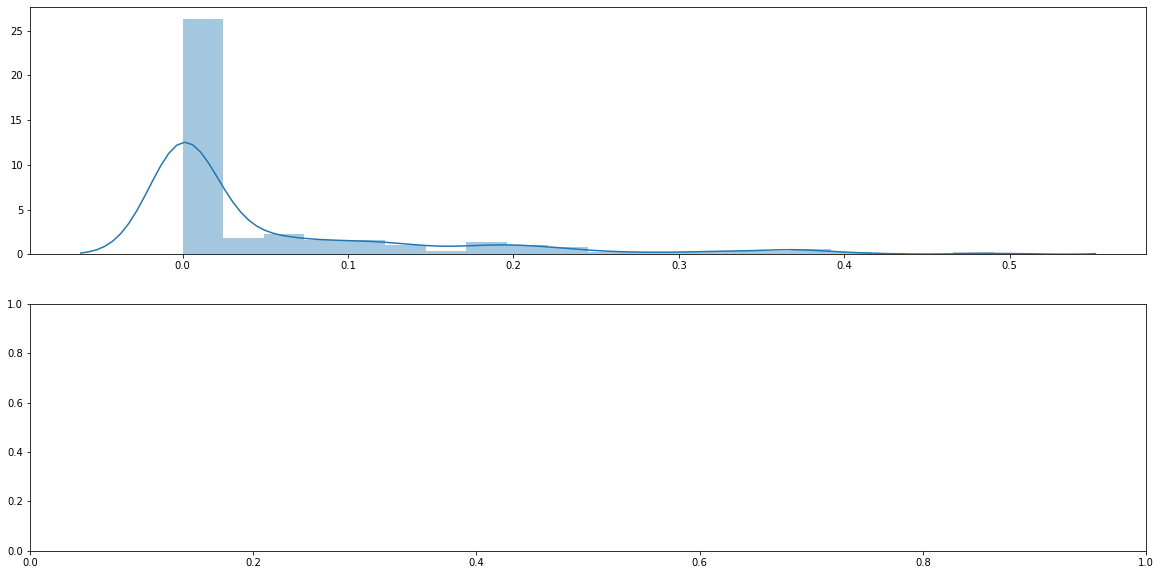

In [33]:

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


f, ax = plt.subplots(ncols = 1, nrows = 2, figsize=(20, 10))

pal = sns.palplot(sns.color_palette("RdBu"))

p = sns.distplot(abs(new_beta), ax = ax[0])

f





In [265]:

predictions_re = (top_N_values * (geno_test.loc[top_N_snps].transpose())).sum(axis = 1)

In [266]:
lm_re = sm.OLS(endog = residuals, exog = geno_tr.loc[top_N_snps].transpose()).fit_regularized(L1_wt = 1.0, alpha = 1.0)

if verbose: 
    print(lm_re.params)

predictions_re2 = lm_re.predict(geno_test.loc[top_N_snps].transpose())


In [267]:
# combine the result from both
total_prediction = predictions_fe + predictions_re


mse = calculate_MSE(total_prediction, pheno_test[phenotype_2])
newmse = calculate_MSE(predictions_fe, pheno_test[phenotype_2])
newnewmse = calculate_MSE(predictions_fe + predictions_re2, pheno_test[phenotype_2])
newnewnewmse, _sample_list = top_N_snp_mixed_model_analysis(geno_df, pheno_df, phenotype_1, phenotype_2, missing_rate = missing_rate, sample_list = test_sample_list, top_N = 10)

print(mse,newmse, newnewmse, newnewnewmse)
# return(mse, test_sample_list)

The correlation between length1 and fat_mri is nan
[4555 1361 4739  948  663 4881  657 1362 2699 2091]
[0.03704802879355403, 0.03787968362660606, -0.038802188736049306, 0.038868415766717936, -0.039070866409710116, 0.040483726260727874, 0.04074132259785157, 0.04133317776789621, 0.04140515721325585, -0.04176636604985238]
Index(['UNC29338764', 'UNC9183051', 'UNC30427502', 'UNC030227936',
       'JAX00102129', 'UNC31514370', 'UNC4287470', 'UNC9183513', 'UNC17550701',
       'UNC13856737'],
      dtype='object', name='marker')
F331    1.271145
F332    0.262697
F337    0.761351
F339   -0.318885
F340    0.304734
F341   -0.393619
F342    0.558698
F345    0.220660
F346   -0.286188
F352    0.220660
F355   -0.318885
F356   -0.795981
F358   -0.488842
F359   -0.205059
F362   -0.351582
F364    0.060043
F368   -0.828678
F374   -0.521539
F377   -0.348637
F380   -0.318885
F383   -0.256436
F390    0.018006
F393    1.841588
F394   -1.103121
F395    0.528946
F396    0.220660
F398    0.761351
F405   -0.011

In [238]:
mse, test_sample_list = phenotype_correlation_analysis(geno_df, pheno_df, phenotype_1, phenotype_2, missing_rate = missing_rate, sample_list=test_sample_list)
mse


The correlation between length1 and fat_mri is nan


21.53870178358285